## Bayesian Neural Network design and inference for regression application using the oceanographic data ##


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install torchbnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
bottle_dataset_path = "/content/gdrive/MyDrive/oceanographic_data/bottle.csv"

cast_dataset_path = "/content/gdrive/MyDrive/oceanographic_data/cast.csv"

In [5]:
bottle_df = pd.read_csv(bottle_dataset_path)

cast_df = pd.read_csv(cast_dataset_path)

<ipython-input-5-edef5146ed16>:1: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  bottle_df = pd.read_csv(bottle_dataset_path)
<ipython-input-5-edef5146ed16>:3: DtypeWarning: Columns (40,41,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  cast_df = pd.read_csv(cast_dataset_path)


## Exploratory Data Analysis (EDA)

In [6]:
bottle_df.head()

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
bottle_df.shape

(864863, 74)

In [8]:
bottle_df.describe()

,Cst_Cnt,Btl_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,BtlNum,...,R_CHLA,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1
count,864863.000000,864863.000000,864863.000000,853900.000000,817509.000000,696201.000000,812174.000000,661274.000000,661268.000000,118667.000000,...,225276.000000,225275.000000,864863.000000,122006.000000,1999.000000,224.000000,2084.000000,234.000000,10.000000,84.000000
mean,17138.790958,432432.000000,226.831951,10.799677,33.840350,3.392468,25.819394,57.103779,148.808694,10.497426,...,0.450225,0.198599,228.395694,162.071521,2153.239714,2168.148330,2256.055845,2278.858803,7.948570,7.910983
std,10240.949817,249664.587269,316.050259,4.243825,0.461843,2.073256,1.167787,37.094137,90.187533,6.189688,...,1.208566,0.376539,319.456731,85.722796,112.995202,154.852332,34.844435,58.496495,0.021216,0.077666
min,1.000000,1.000000,0.000000,1.440000,28.431000,-0.010000,20.934000,-0.100000,-0.434900,0.000000,...,-0.010000,-3.890000,0.000000,0.000000,1948.850000,1969.440000,2181.570000,2198.150000,7.923100,7.618300
25%,8269.000000,216216.500000,46.000000,7.680000,33.488000,1.360000,24.965000,21.100000,60.915470,5.000000,...,0.050000,0.050000,46.000000,200.000000,2028.330000,2008.977500,2230.322500,2229.062500,7.931475,7.898675
50%,16848.000000,432432.000000,125.000000,10.060000,33.863000,3.440000,25.996000,54.400000,151.064150,10.000000,...,0.160000,0.110000,126.000000,206.000000,2170.640000,2265.885000,2244.325000,2247.505000,7.946650,7.928850
75%,26557.000000,648647.500000,300.000000,13.880000,34.196900,5.500000,26.646000,97.600000,240.379600,16.000000,...,0.390000,0.230000,302.000000,214.000000,2253.810000,2315.525000,2278.505000,2316.452500,7.963300,7.955100
max,34404.000000,864863.000000,5351.000000,31.140000,37.034000,11.130000,250.784000,214.100000,485.701800,25.000000,...,66.110000,65.300000,5458.000000,424.000000,2367.800000,2364.420000,2434.900000,2437.000000,7.988300,8.047700


In [9]:
bottle_df.dtypes

Cst_Cnt                  int64
Btl_Cnt                  int64
Sta_ID                  object
Depth_ID                object
Depthm                   int64
                        ...   
TA1                    float64
TA2                    float64
pH2                    float64
pH1                    float64
DIC Quality Comment     object
Length: 74, dtype: object

In [10]:
bottle_df.dtypes.value_counts()

float64    65
int64       5
object      4
dtype: int64

In [11]:
object_columns = bottle_df.select_dtypes(include='object').columns
print(object_columns)

Index(['Sta_ID', 'Depth_ID', 'IncTim', 'DIC Quality Comment'], dtype='object')


In [13]:
int_columns = bottle_df.select_dtypes(include='int64').columns
print(int_columns)

Index(['Cst_Cnt', 'Btl_Cnt', 'Depthm', 'RecInd', 'R_PRES'], dtype='object')


In [15]:
# Check for missing values in the dataset
bottle_df.isnull().sum()

Cst_Cnt                     0
Btl_Cnt                     0
Sta_ID                      0
Depth_ID                    0
Depthm                      0
                        ...  
TA1                    862779
TA2                    864629
pH2                    864853
pH1                    864779
DIC Quality Comment    864808
Length: 74, dtype: int64

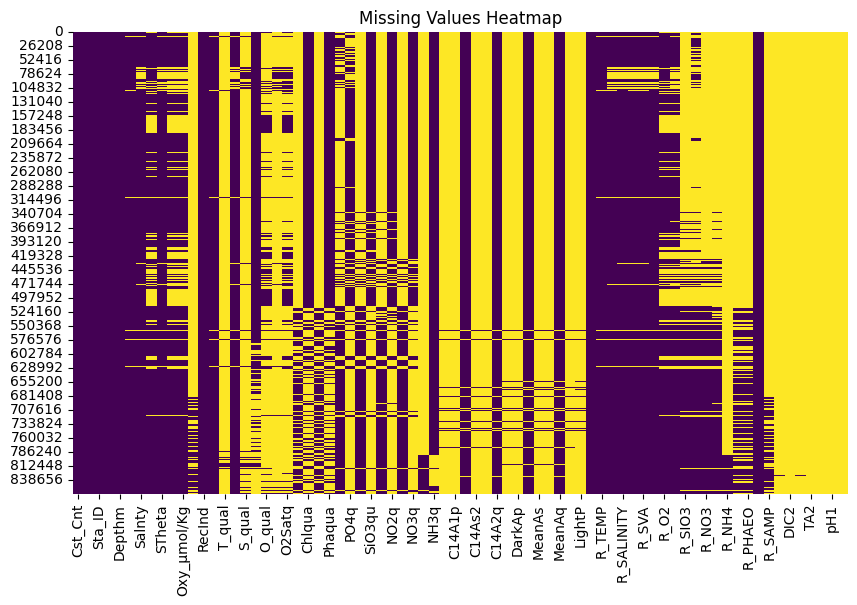

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(bottle_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

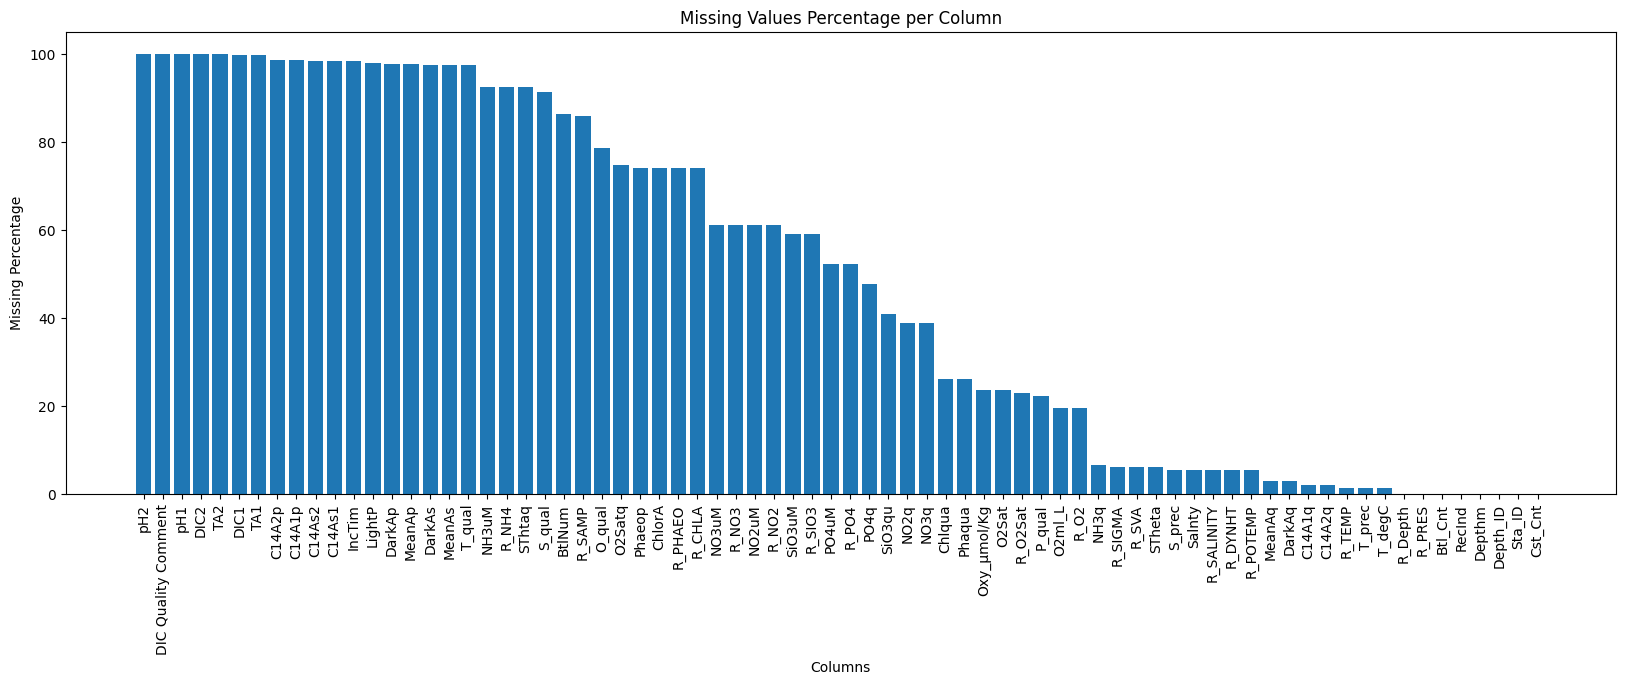

In [19]:
# Calculate the percentage of missing values in each column
missing_percentages = bottle_df.isnull().mean() * 100

# Create a DataFrame to store the missing value percentages
missing_df = pd.DataFrame(missing_percentages, columns=['Missing Percentage'])

# Sort the DataFrame by missing percentage in descending order
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)

# Plot the missing value percentages
plt.figure(figsize=(20, 6))
plt.bar(missing_df.index, missing_df['Missing Percentage'])
plt.xlabel('Columns')
plt.ylabel('Missing Percentage')
plt.title('Missing Values Percentage per Column')
plt.xticks(rotation=90)
plt.show()